We trying

Research Diary: https://drive.google.com/open?id=1zBXLaCameGhHj8RbXeGkep6_gZnUAiAnhGrVE1aEr-4

In [4]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sklearn as sk
import scipy as sp
from scipy import signal
from copy import deepcopy
import math

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

In [35]:
# Force divider function
def force_divider(x):
    k_outer = 3.738
    k_inner = 0.368
    dist = x/k_inner
    return (k_outer + k_inner)*dist

# FSR model function
def FSR_model(x):
    return 131.2*np.exp(0.7801*x)/1000

# Total impulse function for a single matrix of data 
# Iterates over data and computes the total impulse for all sensors over time
def impulse(data_matrix): 
    fsr_data = data_matrix
    impulse = 0
    for col in range(0, 12):
        single_FSR = data_matrix[:,col]
        for i in range(0, 1000):
            averagef = (single_FSR[i+1] + single_FSR[i])/2 
            impulse = impulse + averagef
    return impulse 

# Return a numpy array containing the differential between consecutive elements (approximation of slope) 
# in a given data array
def slope(dataVector):
    dydx = []
    for i in range(1, len(dataVector)):
        diff = dataVector[i] - dataVector[i-1]
        dydx.append(diff)
    finalDiff = dataVector[i] - dataVector[i-1] # Added just to make the final array the proper dimensions 
    dydx.append(finalDiff)
    return np.array(dydx)

# Return a numpy array containing the value and index of the largest magnitude value in given data array (first instance)
def largest(dataVector):
    val = max(abs(dataVector))
    ind = 0
    for k in dataVector:
        if abs(k) == val:
            return np.array([val, ind])
        else:
            ind += 1

# Mean function
def mean(dataVec):
    return sum(dataVec) / len(dataVec)

# Standard Deviation
def sd(dataVec):
    avg = mean(dataVec)
    tot = 0
    for elem in dataVec:
        tot = tot + (elem - avg)*(elem - avg)
    return math.sqrt(tot / len(dataVec))

def standardize(dataVec, targLength):
    numRows, _ = np.shape(dataVec)
    if numRows > 2*targLength:
        while numRows > 2 * targLength:
            dataVec = compress(dataVec)
            numRows, _ = np.shape(dataVec)
    if numRows < targLength:
        while numRows < targLength:
            dataVec = double(dataVec)
            numRows, _ = np.shape(dataVec)
    if numRows == targLength:
        return dataVec
    else:
        return shorten(dataVec, targLength)

def lengthen(dataVec, targLength):
    numRows, numCols = np.shape(dataVec)
    rowsToAdd = targLength - numRows
    while rowsToAdd >= numRows:
        dataVec = lengthen(dataVec, 2 * numRows - 1)
        numRows, numCols = np.shape(dataVec)
        rowsToAdd = targLength - numRows
    retMat = np.empty((targLength, numCols))
    i = 0
    while rowsToAdd > 0:
        if i%2 == 0:
            retMat[i] = dataVec[i//2]
        else:
            rowsToAvg = dataVec[i//2 : i//2 + 2]
            retMat[i] = mean(rowsToAvg)
            rowsToAdd = rowsToAdd - 1
        i = i + 1
    retMat[i:] = dataVec[i // 2 :]
    return retMat

def shorten(dataVec, targLength):
    numRows, numCols = np.shape(dataVec)
    rowsToRemove = numRows - targLength
    while rowsToRemove > targLength:
        dataVec = shorten(dataVec, numRows // 2)
        numRows, numCols = np.shape(dataVec)
        rowsToRemove = numRows - targLength
    retMat = np.empty((targLength, numCols))
    i = 0
    while rowsToRemove > 0:
        rowsToAvg = dataVec[i*2 : i*2 + 2]
        retMat[i] = mean(rowsToAvg)
        rowsToRemove = rowsToRemove - 1
        i = i + 1
    retMat[i:] = dataVec[i*2:]
    return retMat

# Compress function
def compress(data):
    sliceLen = 3
    i = len(data) // sliceLen
    comp = []
    for k in range(0, i):
        vals = data[k*sliceLen:(k+1)*sliceLen]
        avg = mean(vals)
        comp.append(avg)
    return np.array(comp)

def double(data):
    retMat = []
    for _ in np.arange(0, 2):
        retMat.extend(data)
    return np.array(retMat)

In [36]:
a = np.array([[1, 2, 3], [4, 5, 6]])
print(a)
print(double(a))
print(np.shape(double(a)))

[[1 2 3]
 [4 5 6]]
[[1 2 3]
 [4 5 6]
 [1 2 3]
 [4 5 6]]
(4, 3)


In [37]:
# Labels
    # Drop = 1 (starts at ind 0)
    # Handle = 2 (starts at ind 21)
    # Roll = 3 (starts at ind 73)
    # Squeeze = 4 (starts at ind 88)
    # Nothing = 5 (starts at ind 178)

fsrData = []
accelData = []
totData = []
targetLength = 1500
    
# Add Drop data
string = "/Users/alber/Desktop/BEST/Tensegrity-HRI/DataV3/Drop/drop"
numbers = np.arange(1,21)
for num in numbers:
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["IND", "time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
                                              "ACC_X", "ACC_Y", "ACC_Z"])
    fsrDrop = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12"]]
    accelDrop = d[["ACC_X", "ACC_Y", "ACC_Z"]]
    totDrop = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12", "ACC_X", "ACC_Y", "ACC_Z"]]
    fsrDrop = fsrDrop.to_numpy()
    accelDrop = accelDrop.to_numpy()
    totDrop = totDrop.to_numpy()
    fsrDrop = standardize(fsrDrop, targetLength)
    accelDrop = standardize(accelDrop, targetLength)
    totDrop = standardize(totDrop, targetLength)
    fsrData.append(fsrDrop)
    accelData.append(accelDrop)
    totData.append(totDrop)
    
# Add Handle data
string = "/Users/alber/Desktop/BEST/Tensegrity-HRI/DataV3/Handle/handleTest"
numbers = np.arange(1, 53)
for num in numbers:
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["Nothing", "IND", "time", "ACC_X", "ACC_Y", "ACC_Z", "QUAT_W", "QUAT_X", "QUAT_Y", 
                                       "QUAT_Z", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12"])
    fsrHandle = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                "FSR_12"]]
    accelHandle = d[["ACC_X", "ACC_Y", "ACC_Z"]]
    totHandle = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12", "ACC_X", "ACC_Y", "ACC_Z"]]
    fsrHandle = fsrHandle.to_numpy()
    accelHandle = accelHandle.to_numpy()
    totHandle = totHandle.to_numpy()
    fsrHandle = standardize(fsrHandle, targetLength)
    accelHandle = standardize(accelHandle, targetLength)
    totHandle = standardize(totHandle, targetLength)
    fsrData.append(fsrHandle)
    accelData.append(accelHandle)
    totData.append(totHandle)

# Add Roll data
string = "/Users/alber/Desktop/BEST/Tensegrity-HRI/DataV3/Roll/rollTest"
numbers = np.arange(1, 15)
for num in numbers:
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["Nothing", "IND", "time", "ACC_X", "ACC_Y", "ACC_Z", "QUAT_W", "QUAT_X", "QUAT_Y", 
                                       "QUAT_Z", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12"])
    fsrRoll = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                "FSR_12"]]
    accelRoll = d[["ACC_X", "ACC_Y", "ACC_Z"]]
    totRoll = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12", "ACC_X", "ACC_Y", "ACC_Z"]]
    fsrRoll = fsrRoll.to_numpy()
    accelRoll = accelRoll.to_numpy()
    totRoll = totRoll.to_numpy()
    fsrRoll = standardize(fsrRoll, targetLength)
    accelRoll = standardize(accelRoll, targetLength)
    totRoll = standardize(totRoll, targetLength)
    fsrData.append(fsrRoll)
    accelData.append(accelRoll)
    totData.append(totRoll)

    
# Add Squeeze data
string = "/Users/alber/Desktop/BEST/Tensegrity-HRI/DataV3/Squeeze/squeeze"
numbers = np.arange(56, 90)
for num in numbers:
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["IND", "time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
                                              "ACC_X", "ACC_Y", "ACC_Z"])
    fsrSqueeze = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12"]]
    accelSqueeze = d[["ACC_X", "ACC_Y", "ACC_Z"]]
    totSqueeze = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12", "ACC_X", "ACC_Y", "ACC_Z"]]
    fsrSqueeze = fsrSqueeze.to_numpy()
    accelSqueeze = accelSqueeze.to_numpy()
    totSqueeze = totSqueeze.to_numpy()
    fsrSqueeze = standardize(fsrSqueeze, targetLength)
    accelSqueeze = standardize(accelSqueeze, targetLength)
    totSqueeze = standardize(totSqueeze, targetLength)
    fsrData.append(fsrSqueeze)
    accelData.append(accelSqueeze)
    totData.append(totSqueeze)
    
# Add More Squeeze data
string = "/Users/alber/Desktop/BEST/Tensegrity-HRI/DataV3/Squeeze/squeeze"
numbers = np.arange(1, 56)
for num in numbers:
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["Nothing", "IND", "time", "ACC_X", "ACC_Y", "ACC_Z", "QUAT_W", "QUAT_X", "QUAT_Y", 
                                       "QUAT_Z", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12"])
    fsrSqueeze = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12"]]
    accelSqueeze = d[["ACC_X", "ACC_Y", "ACC_Z"]]
    totSqueeze = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12", "ACC_X", "ACC_Y", "ACC_Z"]]
    fsrSqueeze = fsrSqueeze.to_numpy()
    accelSqueeze = accelSqueeze.to_numpy()
    totSqueeze = totSqueeze.to_numpy()
    fsrSqueeze = standardize(fsrSqueeze, targetLength)
    accelSqueeze = standardize(accelSqueeze, targetLength)
    totSqueeze = standardize(totSqueeze, targetLength)
    fsrData.append(fsrSqueeze)
    accelData.append(accelSqueeze)
    totData.append(totSqueeze)
    
# Add Nothing data
string = "/Users/alber/Desktop/BEST/Tensegrity-HRI/DataV3/Nothing/nothing"
numbers = np.arange(48, 57)
for num in numbers:
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["IND", "time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
                                              "ACC_X", "ACC_Y", "ACC_Z"])
    fsrNoth = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12"]]
    accelNoth = d[["ACC_X", "ACC_Y", "ACC_Z"]]
    totNoth = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12", "ACC_X", "ACC_Y", "ACC_Z"]]
    fsrNoth = fsrNoth.to_numpy()
    accelNoth = accelNoth.to_numpy()
    totNoth = totNoth.to_numpy()
    fsrNoth = standardize(fsrNoth, targetLength)
    accelNoth = standardize(accelNoth, targetLength)
    totNoth = standardize(totNoth, targetLength)
    fsrData.append(fsrNoth)
    accelData.append(accelNoth)
    totData.append(totNoth)

# Add More Nothing data
string = "/Users/alber/Desktop/BEST/Tensegrity-HRI/DataV3/Nothing/nothing"
numbers = np.arange(2, 48)
for num in numbers:
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["Nothing", "IND", "time", "ACC_X", "ACC_Y", "ACC_Z", "QUAT_W", "QUAT_X", "QUAT_Y", 
                                       "QUAT_Z", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12"])
    fsrNoth = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12"]]
    accelNoth = d[["ACC_X", "ACC_Y", "ACC_Z"]]
    totNoth = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12", "ACC_X", "ACC_Y", "ACC_Z"]]
    fsrNoth = fsrNoth.to_numpy()
    accelNoth = accelNoth.to_numpy()
    totNoth = totNoth.to_numpy()
    fsrNoth = standardize(fsrNoth, targetLength)
    accelNoth = standardize(accelNoth, targetLength)
    totNoth = standardize(totNoth, targetLength)
    fsrData.append(fsrNoth)
    accelData.append(accelNoth)
    totData.append(totNoth)


print(np.shape(fsrData))
print(np.shape(accelData))
print(np.shape(totData))

(230, 1500, 12)
(230, 1500, 3)
(230, 1500, 15)


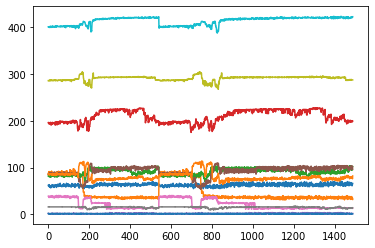

In [38]:
plt.plot(fsrData[186][11:])


In [39]:
# Convert fsr data to Newtons
placeHold = []
for m in fsrData:
    m = force_divider(FSR_model(m *5/1023))  
    placeHold.append(m)

for k in totData:
    k[:, 0:12] = force_divider(FSR_model(k[:, 0:12] *5/1023))

fsrData = placeHold


In [40]:
# Smoothing out fsr data

fsrRefined = deepcopy(fsrData)
for test in fsrRefined:
    for k in range(0, 12):
        test[:, k] = signal.savgol_filter(test[:, k], 71, 3)   


In [41]:
# Smoothing out acceleration data
accelRefined = deepcopy(accelData)

for test in accelRefined:
    for k in range(0, 3):
        test[:, k] = signal.savgol_filter(test[:, k], 71, 3)       


In [42]:
# Smoothing out total Data
totRefined = deepcopy(totData)

for test in totRefined:
    for k in range(0, 15):
        test[:, k] = signal.savgol_filter(test[:, k], 71, 3)       


In [43]:
# Generate slope vectors for accel data
accelSlopes = []
numMats, _, _ = np.shape(accelRefined)
for i in range(0, numMats):
    accelVec = slope(accelRefined[i])
    accelSlopes.append(accelVec)

In [44]:
# Clean acceleration slope data
slopeRefined = deepcopy(accelSlopes)

for test in slopeRefined:
    for k in range(0, 3):
        test[:, k] = signal.savgol_filter(test[:, k], 71, 3)  


In [45]:
# Total data + accelerometer slopes
totSlope = []
numMats, _, _ = np.shape(totRefined)
for i in range(0, numMats):
    combinedData = np.append(totRefined[i], slopeRefined[i], axis = 1)
    totSlope.append(combinedData)


In [46]:
# Labels!

l1 = np.ones((20,), dtype=int) 
l2 = 2*np.ones((52,), dtype=int) 
l3 = 3*np.ones((14,), dtype=int)
l4 = 4*np.ones((89,), dtype=int)
l5 = 5*np.ones((55,), dtype=int)
labels = np.concatenate((l1, l2, l3, l4, l5), axis=0)


# Prepare data for algorithms
nsamples, nx, ny = np.shape(totSlope)
reformated_data = np.reshape(totSlope,(nsamples, nx*ny))
[X_train, X_test, y_train, y_test] = train_test_split(reformated_data, labels, random_state=0)

In [47]:
# K-Fold Cross Validation

X = reformated_data
y = labels
skf = StratifiedKFold(n_splits=4)
skf.get_n_splits(X, y)

4

In [48]:
# Gaussian Naive-Bayes
y_pred_tot = []
y_test_tot = []
all_probs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    nb = GaussianNB().fit(X_train, y_train)
    print("\n")
    print(nb.score(X_test, y_test))
    y_pred = nb.predict(X_test)
    y_pred_tot.extend(y_pred)
    y_test_tot.extend(y_test)
    print("Predicted labels = " + str(y_pred))
    print("Correct labels =   " + str(y_test))
    #print(nb.predict_proba(X_test))
    if len(all_probs) == 0:
        all_probs = nb.predict_proba(X_test)
    else:
        all_probs = np.append(all_probs, nb.predict_proba(X_test), axis = 0)

# print(np.shape(y_pred_tot))
#print(np.shape(y_test_tot))
#print(np.shape(all_probs))



0.7966101694915254
Predicted labels = [1 1 1 4 1 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 1 1 1 1 4 1 1 1 4 5 5 5 5]
Correct labels =   [1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


0.8275862068965517
Predicted labels = [1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 5 2 2 2 2 2 2 2 2 2 5 5 5 2]
Correct labels =   [1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


0.7894736842105263
Predicted labels = [1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 2 2 5 2 2 5 2 2 3 3 3 3 3 3]
Correct labels =   [1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


0.875
Predicted labels = [4 4 4 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 

In [49]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)


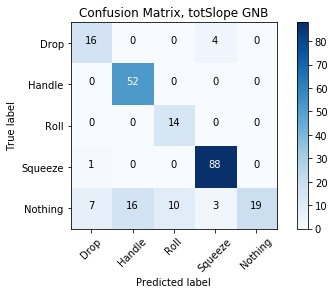

In [50]:
class_names = ['Drop', 'Handle', 'Roll', 'Squeeze', 'Nothing']
pcaFSR_cnf_matrix = confusion_matrix(y_test_tot, y_pred_tot)
plot_confusion_matrix(pcaFSR_cnf_matrix, classes=class_names, title='Confusion Matrix, totSlope GNB')

In [51]:
def prob_matrix(probs, labels):
    retMat = []
    l1Mat = [0, 0, 0, 0, 0]
    l2Mat = [0, 0, 0, 0, 0]
    l3Mat = [0, 0, 0, 0, 0]
    l4Mat = [0, 0, 0, 0, 0]
    l5Mat = [0, 0, 0, 0, 0]
    i = 0
    l1Count = 0
    l2Count = 0
    l3Count = 0
    l4Count = 0
    l5Count = 0
    for k in labels:
        if k == 1:
            l1Mat = l1Mat + probs[i]
            l1Count = l1Count + 1
        if k == 2:
            l2Mat = l2Mat + probs[i]
            l2Count = l2Count + 1
        if k == 3:
            l3Mat = l3Mat + probs[i]
            l3Count = l3Count + 1
        if k == 4:
            l4Mat = l4Mat + probs[i]
            l4Count = l4Count + 1
        if k == 5:
            l5Mat = l5Mat + probs[i]
            l5Count = l5Count + 1
        i = i + 1
    l1Mat = l1Mat / l1Count
    l2Mat = l2Mat / l2Count
    l3Mat = l3Mat / l3Count
    l4Mat = l4Mat / l4Count
    l5Mat = l5Mat / l5Count
    return np.array([l1Mat, l2Mat, l3Mat, l4Mat, l5Mat])

def generate_plot(probability_array, title):
    probability_array = probability_array.T
    label0 = probability_array[0]
    label1 = probability_array[1]
    label2 = probability_array[2]
    label3 = probability_array[3]
    label4 = probability_array[4]

 
    # The position of the bars on the x-axis
    r = [0,1,2,3, 4]
 
    # Names of group and bar width
    names = ['Drop','Handle', 'Roll', 'Squeeze', 'Nothing']
    barWidth = 1
    
    plt.bar(r, label0, color = 'y',edgecolor='white', width=barWidth)
    plt.bar(r, label1, bottom=label0, color='g',edgecolor='white', width=barWidth)
    plt.bar(r, label2, bottom=label1+label0, color='b', edgecolor='white', width=barWidth)
    plt.bar(r, label3, bottom=label2+label1+label0, color = 'c', edgecolor='white', width=barWidth)
    plt.bar(r, label4, bottom=label3+label2+label1+label0, color = 'k', edgecolor='white', width=barWidth)
    plt.legend(('1 (Drop)','2 (Handle)','3 (Roll)', '4 (Squeeze)', '5 (Nothing)'))
 
    plt.xticks(r, names)
    plt.xlabel("true test value")
    plt.ylabel('Probability')
    plt.title(title)

[[0.8        0.         0.         0.2        0.        ]
 [0.         1.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.        ]
 [0.01123596 0.         0.         0.98876404 0.        ]
 [0.12727273 0.29090909 0.18181818 0.05454545 0.34545455]]


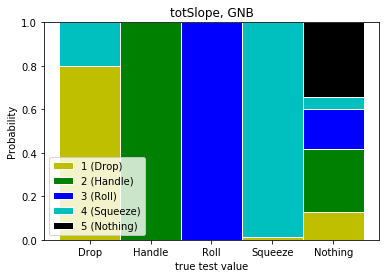

In [52]:
prob_mat = prob_matrix(all_probs, y_test_tot)
print(prob_mat)
generate_plot(prob_mat, 'totSlope, GNB')

In [33]:
# Comparing labels for ROC Curve
twoClasses = totSlope[28:42] + totSlope[42:56]
twoLabels = np.concatenate((l1, l2), axis = 0)

nsamples, nx, ny = np.shape(twoClasses)
reformated_data = np.reshape(twoClasses,(nsamples, nx*ny))
[X_train, X_test, y_train, y_test] = train_test_split(reformated_data, twoLabels, random_state=0)

nb = GaussianNB().fit(X_train, y_train)
print(nb.score(X_test, y_test))
y_pred = nb.predict(X_test)
print("Predicted labels = " + str(y_pred))
print("Correct labels =   " + str(y_test))
print(nb.predict_proba(X_test))
print("\n")

# # Generate ROC Curve
# probs = nb.predict_proba(X_test)[:, 0]
# false_positive_rate_values, sensitivity_values, thresholds = roc_curve(y_test, probs, pos_label=1)

# plt.step(false_positive_rate_values, sensitivity_values, color='b', alpha=0.2,
#          where='post')
# plt.xlabel('False Positive Rate (1 - Specificity)')
# plt.ylabel('Sensitivity')
# plt.title('Fall vs. Impact ROC Curve')

1.0
Predicted labels = [1 2 2 2 1 1 2]
Correct labels =   [1 2 2 2 1 1 2]
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]




In [53]:
# Random Forest
y_pred_tot = []
y_test_tot = []
all_probs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    nb = RandomForestClassifier(n_estimators = 125).fit(X_train, y_train)
    print("\n")
    print(nb.score(X_test, y_test))
    y_pred = nb.predict(X_test)
    y_pred_tot.extend(y_pred)
    y_test_tot.extend(y_test)
    #print("Predicted labels = " + str(y_pred))
    #print("Correct labels =   " + str(y_test))
    #print(nb.predict_proba(X_test))
    if len(all_probs) == 0:
        all_probs = nb.predict_proba(X_test)
    else:
        all_probs = np.append(all_probs, nb.predict_proba(X_test), axis = 0)

#print(np.shape(y_test_tot))
#print(np.shape(all_probs))



0.6610169491525424


0.8448275862068966


0.8771929824561403


0.875


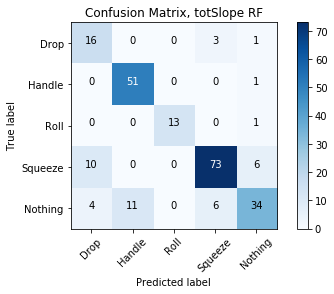

In [54]:
class_names = ['Drop', 'Handle', 'Roll', 'Squeeze', 'Nothing']
pcaFSR_cnf_matrix = confusion_matrix(y_test_tot, y_pred_tot)
plot_confusion_matrix(pcaFSR_cnf_matrix, classes=class_names, title='Confusion Matrix, totSlope RF')

[[0.4988     0.0212     0.0132     0.2992     0.1676    ]
 [0.01138462 0.60630769 0.06723077 0.10261538 0.21246154]
 [0.01371429 0.14514286 0.51142857 0.06685714 0.26285714]
 [0.13204494 0.07110112 0.02292135 0.60889888 0.16503371]
 [0.08727273 0.17730909 0.03985455 0.14894545 0.54661818]]


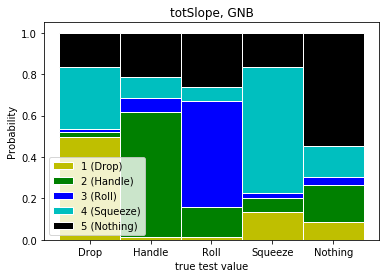

In [55]:
prob_mat = prob_matrix(all_probs, y_test_tot)
print(prob_mat)
generate_plot(prob_mat, 'totSlope, GNB')

0.7857142857142857
Predicted labels = [1 2 1 1 1 1 1 1 1 1 1 1 1 1]
Correct labels =   [1 1 1 2 1 1 1 1 1 1 1 1 1 2]
[[1.  0. ]
 [0.3 0.7]
 [0.9 0.1]
 [0.6 0.4]
 [1.  0. ]
 [0.9 0.1]
 [1.  0. ]
 [1.  0. ]
 [1.  0. ]
 [0.8 0.2]
 [1.  0. ]
 [0.8 0.2]
 [0.7 0.3]
 [0.6 0.4]]


AUC: 0.9166666666666667


C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


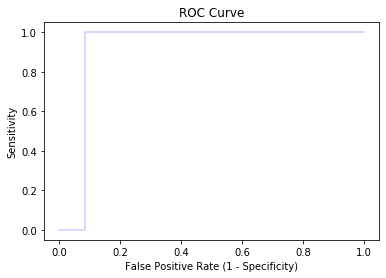

In [123]:
# Comparing labels for ROC Curve
twoLabels = np.concatenate((l1, l2, l1, l1), axis = 0)

nsamples, nx, ny = np.shape(totSlope)
reformated_data = np.reshape(totSlope,(nsamples, nx*ny))
[X_train, X_test, y_train, y_test] = train_test_split(reformated_data, twoLabels, random_state=0)

nb = RandomForestClassifier().fit(X_train, y_train)
print(nb.score(X_test, y_test))
y_pred = nb.predict(X_test)
print("Predicted labels = " + str(y_pred))
print("Correct labels =   " + str(y_test))
print(nb.predict_proba(X_test))
print("\n")

# Generate ROC Curve
probs = nb.predict_proba(X_test)[:, 0]
prob2 = nb.predict_proba(X_test)[:, 1]
false_positive_rate_values, sensitivity_values, thresholds = roc_curve(y_test, prob2, pos_label=2)

plt.step(false_positive_rate_values, sensitivity_values, color='b', alpha=0.2,
         where='post')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('Sensitivity')

plt.title('ROC Curve')

print("AUC: " + str(roc_auc_score(y_test, prob2)))

In [23]:
# Looping over various parameters to systematically check AUC
aucArray = []
for param in np.arange(1000, 5000, 10):
    aucSubArray = []
    for i in range(0, 5):
        twoLabels = np.concatenate((l1, l1, l2, l1), axis = 0)

        nsamples, nx, ny = np.shape(totSlope)
        reformated_data = np.reshape(totSlope,(nsamples, nx*ny))
        [X_train, X_test, y_train, y_test] = train_test_split(reformated_data, twoLabels, random_state=0)

        nb = RandomForestClassifier(max_depth = param).fit(X_train, y_train)
        y_pred = nb.predict(X_test)

        # Generate ROC Curve
        prob2 = nb.predict_proba(X_test)[:, 1]
        false_positive_rate_values, sensitivity_values, thresholds = roc_curve(y_test, prob2, pos_label=2)

        aucSubArray.append(roc_auc_score(y_test, prob2))
    aucArray.append([param, mean(aucSubArray)])
print(np.shape(aucArray))

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

(400, 2)


C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [24]:
df = pd.DataFrame(aucArray, columns = ['Max Depth', 'AUC Scores'])
df.to_excel('C:/Users/alber/Desktop/BEST/Tensegrity-HRI/AUC_MD_3_ext.xlsx', sheet_name = 'Sheet1')

In [56]:
# PCA on total data

pcaTot = deepcopy(totRefined)
pca = PCA(n_components = 1)
numMats, _, _ = np.shape(pcaTot)
for i in range(0, numMats):
    pcaTot[i] = pca.fit_transform(pcaTot[i])

In [57]:
# Run script on data

# Prepare data for algorithms
nsamples2, nx2, ny2 = np.shape(pcaTot)
reformated_data2 = np.reshape(pcaTot,(nsamples2, nx2*ny2))
[X_train2, X_test2, y_train2, y_test2] = train_test_split(reformated_data2, labels, random_state=0)

# K-Fold Cross Validation
X2 = reformated_data2
y2 = labels
skf2 = StratifiedKFold(n_splits=4)
skf2.get_n_splits(X2, y2)

# Gaussian Naive-Bayes
y_pred_tot = []
y_test_tot = []
all_probs = []
for train_index, test_index in skf.split(X2, y2):
    X_train, X_test, y_train, y_test = X2[train_index], X2[test_index], y2[train_index], y2[test_index]
    nb = GaussianNB().fit(X_train, y_train)
    print("\n")
    print(nb.score(X_test, y_test))
    y_pred = nb.predict(X_test)
    y_pred_tot.extend(y_pred)
    y_test_tot.extend(y_test)
    print("Predicted labels = " + str(y_pred))
    print("Correct labels =   " + str(y_test))
    #print(nb.predict_proba(X_test))
    if len(all_probs) == 0:
        all_probs = nb.predict_proba(X_test)
    else:
        all_probs = np.append(all_probs, nb.predict_proba(X_test), axis = 0)

# print(np.shape(y_pred_tot))
#print(np.shape(y_test_tot))
#print(np.shape(all_probs))



0.576271186440678
Predicted labels = [4 1 2 1 4 2 2 2 2 2 2 2 2 4 2 2 2 2 4 4 3 2 4 1 5 5 4 5 2 4 4 5 5 5 2 3 4
 4 2 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5 5 5 1 5 5]
Correct labels =   [1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


0.7586206896551724
Predicted labels = [1 1 4 4 4 2 2 2 4 2 2 4 2 4 4 4 2 2 3 2 3 3 4 4 4 2 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 2 2 5 4 1 5 5 5 5 5 5 5 5 5 5 5]
Correct labels =   [1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


0.7017543859649122
Predicted labels = [1 1 4 1 1 2 2 2 2 3 1 2 4 2 2 2 1 2 2 3 3 4 1 4 4 1 1 2 2 4 1 1 4 4 4 4 1
 2 1 2 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
Correct labels =   [1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


0.5714285714285714
Predicted labels = [2 2 2 2 1 2 2 2 2 2 2 2 2 4 2 2 2 1 2 3 3 1 1 3 3 5 4 2 2 2 4 2 4 4 1

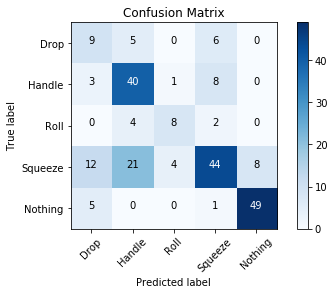

In [58]:
class_names = ['Drop', 'Handle', 'Roll', 'Squeeze', 'Nothing']
pcaFSR_cnf_matrix = confusion_matrix(y_test_tot, y_pred_tot)
plot_confusion_matrix(pcaFSR_cnf_matrix, classes=class_names, title='Confusion Matrix')

[[4.50000000e-01 2.50000000e-01 3.33857335e-47 3.00000000e-01
  0.00000000e+00]
 [5.76665171e-02 7.69113031e-01 1.92565566e-02 1.53963896e-01
  0.00000000e+00]
 [3.38254583e-24 2.85731561e-01 5.71411296e-01 1.42857143e-01
  0.00000000e+00]
 [1.34632304e-01 2.35955036e-01 4.49455791e-02 4.94579441e-01
  8.98876404e-02]
 [9.09090955e-02 3.09598164e-23 9.08293661e-61 1.81818182e-02
  8.90909086e-01]]


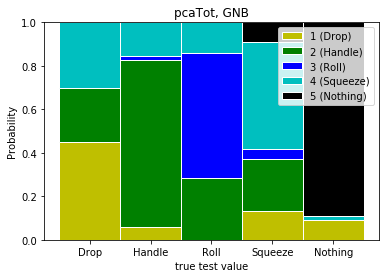

In [59]:
prob_mat = prob_matrix(all_probs, y_test_tot)
print(prob_mat)
generate_plot(prob_mat, 'pcaTot, GNB')

In [60]:
# Comparing labels for ROC Curve
twoClasses = pcaTot[14:28] + pcaTot[42:56]
twoLabels = np.concatenate((l1, l2), axis = 0)

nsamples, nx, ny = np.shape(twoClasses)
reformated_data = np.reshape(twoClasses,(nsamples, nx*ny))
[X_train, X_test, y_train, y_test] = train_test_split(reformated_data, twoLabels, random_state=0)

nb = GaussianNB().fit(X_train, y_train)
print(nb.score(X_test, y_test))
y_pred = nb.predict(X_test)
print("Predicted labels = " + str(y_pred))
print("Correct labels =   " + str(y_test))
print(nb.predict_proba(X_test))
print("\n")

# Generate ROC Curve
probs = nb.predict_proba(X_test)[:, 0]
prob2 = nb.predict_proba(X_test)[:, 1]
false_positive_rate_values, sensitivity_values, thresholds = roc_curve(y_test, prob2, pos_label=2)

plt.step(false_positive_rate_values, sensitivity_values, color='b', alpha=0.2,
         where='post')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('Sensitivity')

plt.title('ROC Curve')

print("AUC: " + str(roc_auc_score(y_test, prob2)))

ValueError: Found input variables with inconsistent numbers of samples: [28, 72]

In [61]:
# Random Forest
y_pred_tot = []
y_test_tot = []
all_probs = []
for train_index, test_index in skf.split(X2, y2):
    X_train, X_test, y_train, y_test = X2[train_index], X2[test_index], y2[train_index], y2[test_index]
    nb = RandomForestClassifier(n_estimators = 125).fit(X_train, y_train)
    print("\n")
    print(nb.score(X_test, y_test))
    y_pred = nb.predict(X_test)
    y_pred_tot.extend(y_pred)
    y_test_tot.extend(y_test)
    #print("Predicted labels = " + str(y_pred))
    #print("Correct labels =   " + str(y_test))
    #print(nb.predict_proba(X_test))
    if len(all_probs) == 0:
        all_probs = nb.predict_proba(X_test)
    else:
        all_probs = np.append(all_probs, nb.predict_proba(X_test), axis = 0)

#print(np.shape(y_test_tot))
#print(np.shape(all_probs))



0.7457627118644068


0.8620689655172413


0.9298245614035088


0.7678571428571429


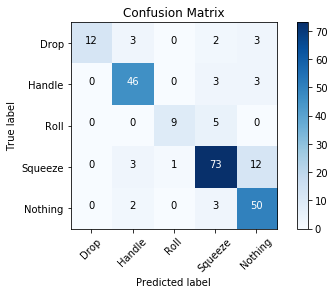

In [62]:
class_names = ['Drop', 'Handle', 'Roll', 'Squeeze', 'Nothing']
pcaFSR_cnf_matrix = confusion_matrix(y_test_tot, y_pred_tot)
plot_confusion_matrix(pcaFSR_cnf_matrix, classes=class_names, title='Confusion Matrix')

[[0.4516     0.1688     0.0392     0.1956     0.1448    ]
 [0.07476923 0.66815385 0.05446154 0.13153846 0.07107692]
 [0.10114286 0.16971429 0.35885714 0.292      0.07828571]
 [0.0828764  0.11523596 0.06516854 0.58606742 0.15065169]
 [0.01876364 0.02647273 0.00610909 0.10414545 0.84450909]]


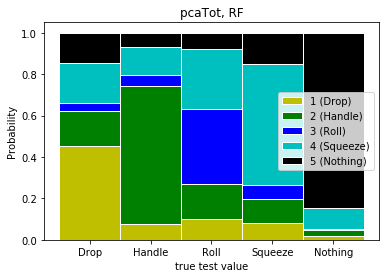

In [34]:
prob_mat = prob_matrix(all_probs, y_test_tot)
print(prob_mat)
generate_plot(prob_mat, 'pcaTot, RF')

0.9285714285714286
Predicted labels = [1 1 1 2 1 1 1 1 1 1 1 1 1 1]
Correct labels =   [1 1 1 2 1 1 1 1 1 1 1 1 1 2]
[[0.95625 0.04375]
 [1.      0.     ]
 [1.      0.     ]
 [0.26125 0.73875]
 [0.9975  0.0025 ]
 [1.      0.     ]
 [1.      0.     ]
 [0.57625 0.42375]
 [0.9375  0.0625 ]
 [1.      0.     ]
 [0.9975  0.0025 ]
 [0.98625 0.01375]
 [1.      0.     ]
 [0.52    0.48   ]]


AUC: 1.0


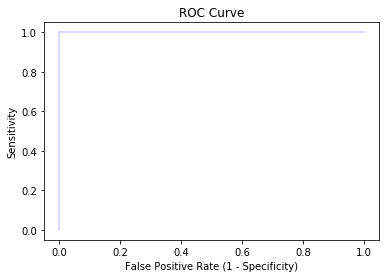

In [128]:
# Comparing labels for ROC Curve
twoLabels = np.concatenate((l1, l2, l1, l1), axis = 0)

nsamples, nx, ny = np.shape(pcaTot)
reformated_data = np.reshape(pcaTot,(nsamples, nx*ny))
[X_train, X_test, y_train, y_test] = train_test_split(reformated_data, twoLabels, random_state=0)

nb = RandomForestClassifier(n_estimators = 800).fit(X_train, y_train)
print(nb.score(X_test, y_test))
y_pred = nb.predict(X_test)
print("Predicted labels = " + str(y_pred))
print("Correct labels =   " + str(y_test))
print(nb.predict_proba(X_test))
print("\n")

# Generate ROC Curve
prob2 = nb.predict_proba(X_test)[:, 1]
false_positive_rate_values, sensitivity_values, thresholds = roc_curve(y_test, prob2, pos_label=2)

plt.step(false_positive_rate_values, sensitivity_values, color='b', alpha=0.2,
         where='post')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('Sensitivity')

plt.title('ROC Curve')

print("AUC: " + str(roc_auc_score(y_test, prob2)))

In [93]:
# Looping over various parameters to systematically check AUC
twoLabels = np.concatenate((l1, l1, l1, l2), axis = 0)

nsamples, nx, ny = np.shape(pcaTot)
reformated_data = np.reshape(pcaTot,(nsamples, nx*ny))
[X_train, X_test, y_train, y_test] = train_test_split(reformated_data, twoLabels, random_state=0)

aucArray = []
for param in np.arange(500, 1010, 10):
    aucSubArray = []
    for i in range(0, 5):
        nb = RandomForestClassifier(max_depth = param).fit(X_train, y_train)
        y_pred = nb.predict(X_test)

        # Generate ROC Curve
        prob2 = nb.predict_proba(X_test)[:, 1]
        false_positive_rate_values, sensitivity_values, thresholds = roc_curve(y_test, prob2, pos_label=2)

        aucSubArray.append(roc_auc_score(y_test, prob2))
    aucArray.append([param, mean(aucSubArray)])
print(np.shape(aucArray))

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

(51, 2)


C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

In [94]:
df = pd.DataFrame(aucArray, columns = ['Num Trees', 'AUC Scores'])
df.to_excel('C:/Users/alber/Desktop/BEST/Tensegrity-HRI/AUC_MD_4_ext.xlsx', sheet_name = 'Sheet1')

(230, 1500, 1)


Text(0.5, 1.0, 'Nothing')

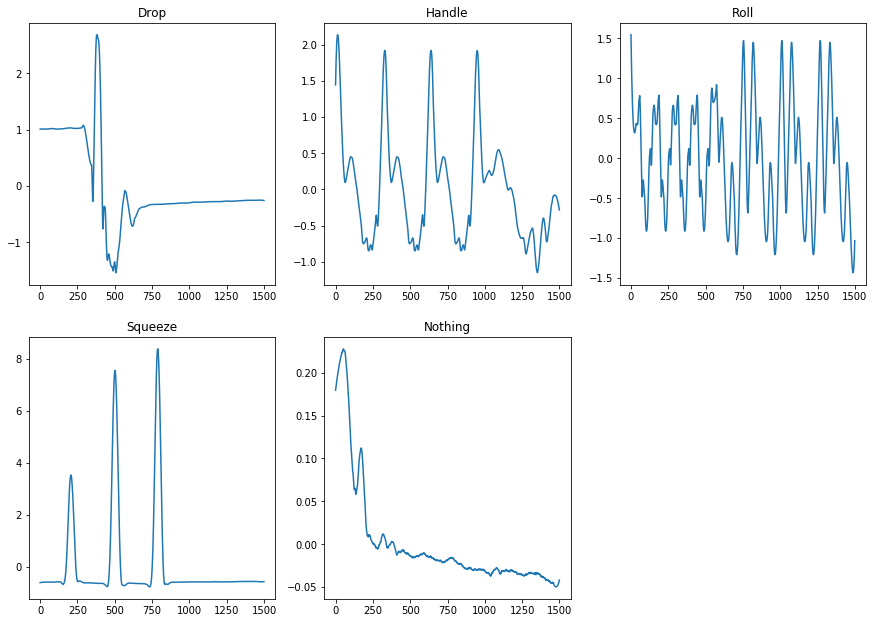

In [63]:
# PCA, just FSR
pcaFSR = deepcopy(fsrRefined)
pca = PCA(n_components = 1)

for i in range(0, len(pcaFSR)):
    pcaFSR[i] = pca.fit_transform(pcaFSR[i])


print(np.shape(pcaFSR))
plt.figure(figsize=(15, 10))
plt.subplots_adjust(bottom=0.1, top = 0.9, hspace=0.2)
plt.subplot(231)
plt.plot(pcaFSR[0])
plt.title('Drop')

plt.subplot(232)
plt.plot(pcaFSR[21])
plt.title('Handle')

plt.subplot(233)
plt.plot(pcaFSR[73])
plt.title('Roll')

plt.subplot(234)
plt.plot(pcaFSR[88])
plt.title('Squeeze')

plt.subplot(235)
plt.plot(pcaFSR[178])
plt.title('Nothing')

In [64]:
# Prepare data for algorithms
nsamples2, nx2, ny2 = np.shape(pcaFSR)
reformated_data2 = np.reshape(pcaFSR,(nsamples2, nx2*ny2))
[X_train2, X_test2, y_train2, y_test2] = train_test_split(reformated_data2, labels, random_state=0)

# K-Fold Cross Validation
X2 = reformated_data2
y2 = labels
skf2 = StratifiedKFold(n_splits=4)
skf2.get_n_splits(X2, y2)

# Random Forest
y_pred_tot = []
y_test_tot = []
all_probs = []
for train_index, test_index in skf.split(X2, y2):
    X_train, X_test, y_train, y_test = X2[train_index], X2[test_index], y2[train_index], y2[test_index]
    nb = RandomForestClassifier(n_estimators = 125).fit(X_train, y_train)
    print("\n")
    print(nb.score(X_test, y_test))
    y_pred = nb.predict(X_test)
    y_pred_tot.extend(y_pred)
    y_test_tot.extend(y_test)
    #print("Predicted labels = " + str(y_pred))
    #print("Correct labels =   " + str(y_test))
    #print(nb.predict_proba(X_test))
    if len(all_probs) == 0:
        all_probs = nb.predict_proba(X_test)
    else:
        all_probs = np.append(all_probs, nb.predict_proba(X_test), axis = 0)



0.7627118644067796


0.9137931034482759


0.8771929824561403


0.8035714285714286


In [65]:
# Gaussian Naive-Bayes
y_pred_tot = []
y_test_tot = []
all_probs = []
for train_index, test_index in skf.split(X2, y2):
    X_train, X_test, y_train, y_test = X2[train_index], X2[test_index], y2[train_index], y2[test_index]
    nb = GaussianNB().fit(X_train, y_train)
    print("\n")
    print(nb.score(X_test, y_test))
    y_pred = nb.predict(X_test)
    y_pred_tot.extend(y_pred)
    y_test_tot.extend(y_test)
    print("Predicted labels = " + str(y_pred))
    print("Correct labels =   " + str(y_test))
    #print(nb.predict_proba(X_test))
    if len(all_probs) == 0:
        all_probs = nb.predict_proba(X_test)
    else:
        all_probs = np.append(all_probs, nb.predict_proba(X_test), axis = 0)



0.7966101694915254
Predicted labels = [1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 2 3 2 3 1 4 4 2 2 4 2 4 4 4 2 2 2 4 4 4
 4 4 4 4 4 4 4 4 5 1 3 5 3 5 5 5 5 5 5 5 5 5]
Correct labels =   [1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


0.9482758620689655
Predicted labels = [1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 5 3 5 5 5 5 5 5 5 5 5 5 5 5]
Correct labels =   [1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


0.9649122807017544
Predicted labels = [1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
Correct labels =   [1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


0.7142857142857143
Predicted labels = [2 2 3 2 1 2 3 2 3 2 3 2 2 3 2 3 2 2 3 2 2 4 4 4 4 2 4 4 4 4 4 4 4 4 